# Investigating Hybrid Strategies for Systematic Literature Review

In [1]:
%matplotlib inline

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                (" visited", len(current.visited)),
                (" selected", len(current.related)),  #  ("WorkSnowball", len(current.related)),
                #("selected", len(current.final_selected)),
                #("seed_set", len(current.seed_set)),
            ]
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            (" visited", len(current.delta_visited)),
                            (" selected", len(current.delta_related)),
                            #("selected", len(current.delta_selected)),
                            #("seed_set", len(current.delta_seed_set)),
                        ]
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)


def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "fmeasure", 
        "final_precision", "final_recall", "final_fmeasure", 
        "operation", "delta_related", "delta_visited", "delta_selected",
        "related", "visited", "final_selected",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure",
        "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
            
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

# Strategies

## Strategy 1 - Database Search

In [3]:
print ("Total de estudos primários reproduzidos: 22 do Seed Set + 29 encontrados durante o Snowballing = ", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))

Total de estudos primários reproduzidos: 22 do Seed Set + 29 encontrados durante o Snowballing =  51


In [4]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if getattr(x, "seed_set", 0)}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("ieee2015", filter_function=filter_function)) # busca simples

state = strategy.initial
strategy.initial.visited

FinalSelection(state);

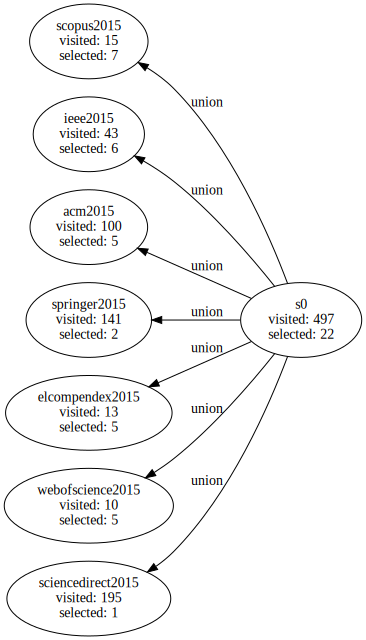

In [5]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0") 
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus2015", "ieee2015", "acm2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015"], filter_function)
state = strategy.initial
FinalSelection(strategy.initial)

In [6]:
array = []
name = "E1"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df = df.round(4)
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

8,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,sciencedirect2015,0.005,0.045,0.009,0.0,0.0,0,-,1,195,0,1,195,1,0.005,0.045,0.009,0.005,0.033,0.009
1,webofscience2015,0.500,0.227,0.312,0.0,0.0,0,-,5,10,0,5,10,4,0.500,0.227,0.312,0.400,0.133,0.200
2,elcompendex2015,0.385,0.227,0.286,0.0,0.0,0,-,5,13,0,5,13,5,0.385,0.227,0.286,0.385,0.167,0.233
3,springer2015,0.014,0.091,0.025,0.0,0.0,0,-,2,141,0,2,141,1,0.014,0.091,0.025,0.007,0.033,0.012
4,acm2015,0.050,0.227,0.082,0.0,0.0,0,-,5,100,0,5,100,3,0.050,0.227,0.082,0.030,0.100,0.046
5,ieee2015,0.140,0.273,0.185,0.0,0.0,0,-,6,43,0,6,43,4,0.140,0.273,0.185,0.093,0.133,0.110
6,scopus2015,0.467,0.318,0.378,0.0,0.0,0,-,7,15,0,7,15,6,0.467,0.318,0.378,0.400,0.200,0.267
7,s0,NaN,0.000,0.000,NaN,0.0,0,union,0,0,0,22,497,15,0.044,1.000,0.085,0.030,0.500,0.057


## Strategy 2 - Database Search + Snowballing (Guideline Wohlin)

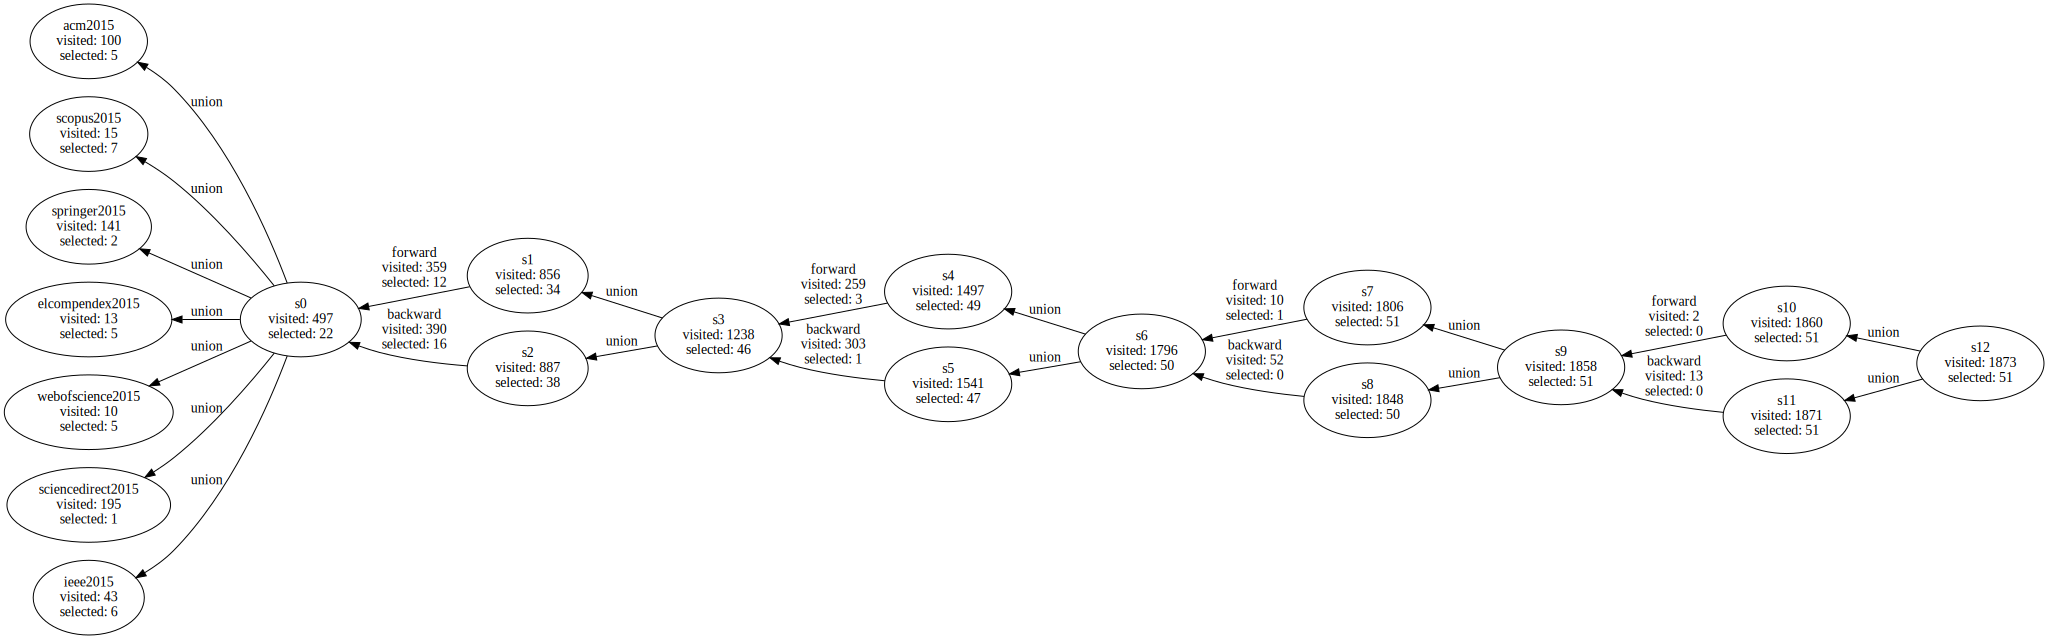

In [7]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm2015", "scopus2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015", "ieee2015"], filter_function)
state = strategy.sfbu()

FinalSelection(state)

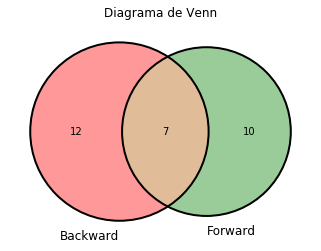

In [8]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [9]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['liu2005a', 'münch2013a', 'basili2007c', 'mandić2010d', 'kowalczyk2010a', 'mcloughlin2010a', 'basili2007a', 'trendowicz2011a', 'murugappan2003a', 'liu2006a', 'armbrust2010a', 'münch2013c', 'mccoy1998a', 'messnarz1999a', 'debou2000a', 'lepmets2014a', 'martins2007b', 'hinley1995a', 'basili2007b']
Forward ['mcloughlin2010b', 'armbrust2010b', 'trendowicz2014a', 'trienekens2004a', 'münch2013a', 'mandić2010d', 'kowalczyk2010a', 'mcloughlin2010a', 'cocozza2014a', 'sun2010a', 'karlström2002a', 'stallinger2013a', 'armbrust2010a', 'unterkalmsteiner2014a', 'münch2013c', 'birkhölzer2011a', 'trendowicz2011a']


In [10]:
name = "E2"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))
        
df

20,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,ieee2015,0.140,0.118,0.128,0.000,0.000,0.000,-,6,43,0,6,43,4,0.140,0.118,0.128,0.093,0.133,0.110
1,sciencedirect2015,0.005,0.020,0.008,0.000,0.000,0.000,-,1,195,0,1,195,1,0.005,0.020,0.008,0.005,0.033,0.009
2,webofscience2015,0.500,0.098,0.164,0.000,0.000,0.000,-,5,10,0,5,10,4,0.500,0.098,0.164,0.400,0.133,0.200
3,elcompendex2015,0.385,0.098,0.156,0.000,0.000,0.000,-,5,13,0,5,13,5,0.385,0.098,0.156,0.385,0.167,0.233
4,springer2015,0.014,0.039,0.021,0.000,0.000,0.000,-,2,141,0,2,141,1,0.014,0.039,0.021,0.007,0.033,0.012
5,scopus2015,0.467,0.137,0.212,0.000,0.000,0.000,-,7,15,0,7,15,6,0.467,0.137,0.212,0.400,0.200,0.267
6,acm2015,0.050,0.098,0.066,0.000,0.000,0.000,-,5,100,0,5,100,3,0.050,0.098,0.066,0.030,0.100,0.046
7,s0,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,22,497,15,0.044,0.431,0.080,0.030,0.500,0.057
8,s2,0.041,0.314,0.073,0.021,0.267,0.038,backward,16,390,8,38,887,23,0.043,0.745,0.081,0.026,0.767,0.050
9,s1,0.033,0.235,0.059,0.014,0.167,0.026,forward,12,359,5,34,856,20,0.040,0.667,0.075,0.023,0.667,0.045


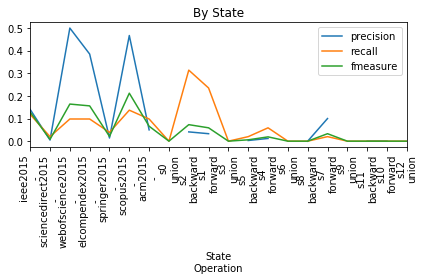

In [11]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
df['fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

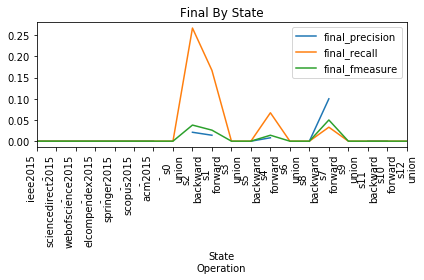

In [12]:
fig = plt.figure()
df['final_precision'].plot(legend=True)
df['final_recall'].plot(legend=True)
df['final_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Final By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

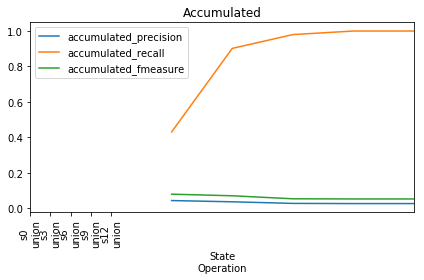

In [13]:
# ---- Grafico de linha para Somente Union 

ndf = df.loc[df['operation'] == 'union']
fig = plt.figure()
ndf['accumulated_precision'].plot(legend=True)
ndf['accumulated_recall'].plot(legend=True)
ndf['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(ndf["state"] + "\n" + ndf["operation"])
plt.xticks(np.arange(0, len(ndf), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()


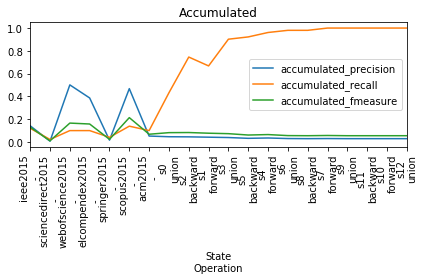

In [14]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
df['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()

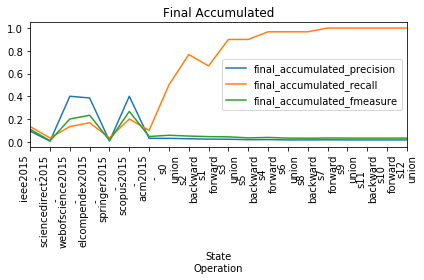

In [15]:
fig = plt.figure()
df['final_accumulated_precision'].plot(legend=True)
df['final_accumulated_recall'].plot(legend=True)
df['final_accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Final Accumulated");
plt.tight_layout()

## Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)

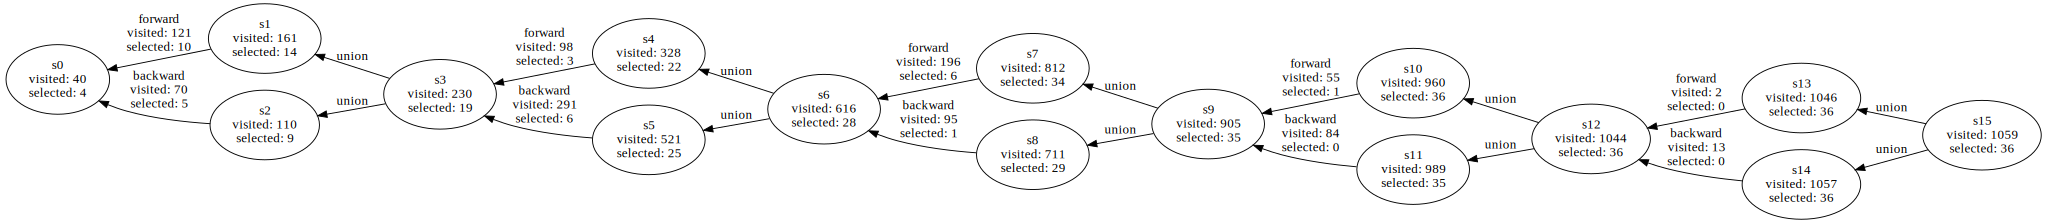

In [16]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
FinalSelection(state)

In [17]:
name = "E3"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

16,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.100,0.078,0.088,0.000,0.000,0.000,-,4,40,0,4,40,3,0.100,0.078,0.088,0.075,0.100,0.086
1,s2,0.071,0.098,0.083,0.071,0.167,0.100,backward,5,70,5,9,110,8,0.082,0.176,0.112,0.073,0.267,0.114
2,s1,0.083,0.196,0.116,0.025,0.100,0.040,forward,10,121,3,14,161,6,0.087,0.275,0.132,0.037,0.200,0.063
3,s3,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,19,230,11,0.083,0.373,0.135,0.048,0.367,0.085
4,s5,0.021,0.118,0.035,0.014,0.133,0.025,backward,6,291,4,25,521,15,0.048,0.490,0.087,0.029,0.500,0.054
5,s4,0.031,0.059,0.040,0.020,0.067,0.031,forward,3,98,2,22,328,13,0.067,0.431,0.116,0.040,0.433,0.073
6,s6,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,28,616,17,0.045,0.549,0.084,0.028,0.567,0.053
7,s8,0.011,0.020,0.014,0.000,0.000,0.000,backward,1,95,0,29,711,17,0.041,0.569,0.076,0.024,0.567,0.046
8,s7,0.031,0.118,0.049,0.020,0.133,0.035,forward,6,196,4,34,812,21,0.042,0.667,0.079,0.026,0.700,0.050
9,s9,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,35,905,21,0.039,0.686,0.073,0.023,0.700,0.045



## Strategy 4 - Scopus + Snowballing (Guideline Wohlin)

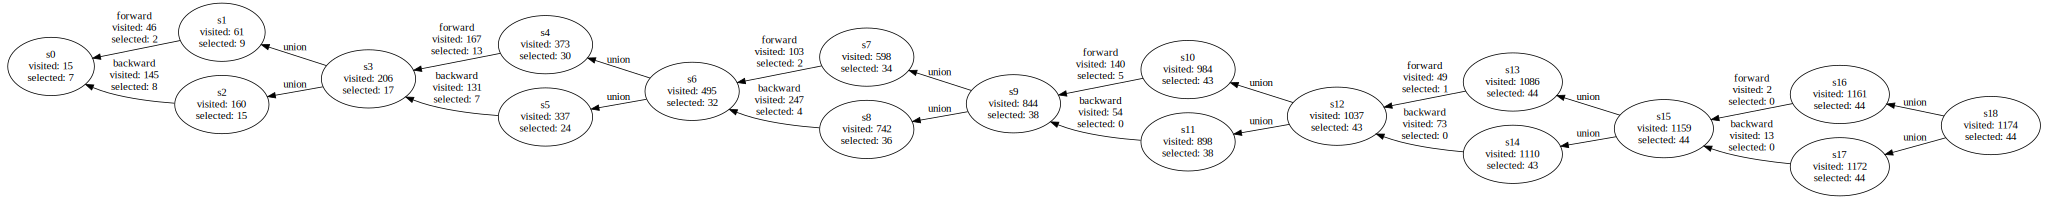

In [18]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))

state = strategy.sfbu()
FinalSelection(state)

In [19]:
name = "E4"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

19,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.467,0.137,0.212,0.000,0.000,0.000,-,7,15,0,7,15,6,0.467,0.137,0.212,0.400,0.200,0.267
1,s2,0.055,0.157,0.082,0.041,0.200,0.069,backward,8,145,6,15,160,12,0.094,0.294,0.142,0.075,0.400,0.126
2,s1,0.043,0.039,0.041,0.000,0.000,0.000,forward,2,46,0,9,61,6,0.148,0.176,0.161,0.098,0.200,0.132
3,s3,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,17,206,12,0.083,0.333,0.132,0.058,0.400,0.102
4,s5,0.053,0.137,0.077,0.023,0.100,0.037,backward,7,131,3,24,337,15,0.071,0.471,0.124,0.045,0.500,0.082
5,s4,0.078,0.255,0.119,0.030,0.167,0.051,forward,13,167,5,30,373,17,0.080,0.588,0.142,0.046,0.567,0.084
6,s6,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,32,495,19,0.065,0.627,0.117,0.038,0.633,0.072
7,s8,0.016,0.078,0.027,0.004,0.033,0.007,backward,4,247,1,36,742,20,0.049,0.706,0.091,0.027,0.667,0.052
8,s7,0.019,0.039,0.026,0.010,0.033,0.015,forward,2,103,1,34,598,20,0.057,0.667,0.105,0.033,0.667,0.064
9,s9,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,38,844,21,0.045,0.745,0.085,0.025,0.700,0.048


## Strategy 5 - Scopus + Snowballing (Short Paper)

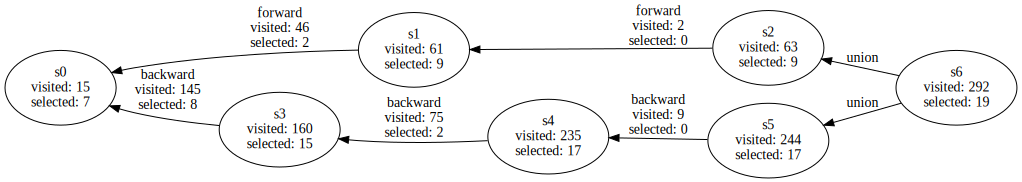

In [20]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.s2bbff2u()
FinalSelection(state)

In [21]:
name = "E5"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

7,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s3,0.055,0.157,0.082,0.041,0.200,0.069,backward,8,145,6,15,160,12,0.094,0.294,0.142,0.075,0.400,0.126
1,s0,0.467,0.137,0.212,0.000,0.000,0.000,-,7,15,0,7,15,6,0.467,0.137,0.212,0.400,0.200,0.267
2,s4,0.027,0.039,0.032,0.027,0.067,0.038,backward,2,75,2,17,235,14,0.072,0.333,0.119,0.060,0.467,0.106
3,s1,0.043,0.039,0.041,0.000,0.000,0.000,forward,2,46,0,9,61,6,0.148,0.176,0.161,0.098,0.200,0.132
4,s5,0.000,0.000,0.000,0.000,0.000,0.000,backward,0,9,0,17,244,14,0.070,0.333,0.115,0.057,0.467,0.102
5,s2,0.000,0.000,0.000,0.000,0.000,0.000,forward,0,2,0,9,63,6,0.143,0.176,0.158,0.095,0.200,0.129
6,s6,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,19,292,14,0.065,0.373,0.111,0.048,0.467,0.087


## Strategy 6 - Scopus + Snowballing (JF BF)

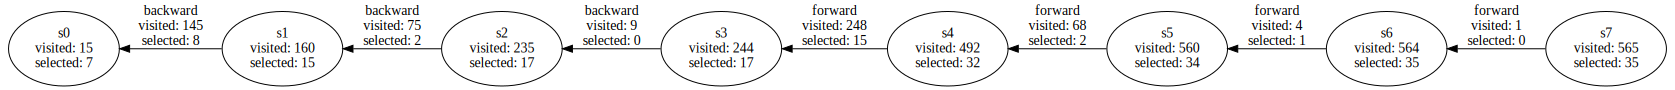

In [22]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.bbff()
FinalSelection(state)

In [23]:
name = "E6"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

8,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.467,0.137,0.212,0.000,0.000,0.000,-,7,15,0,7,15,6,0.467,0.137,0.212,0.400,0.200,0.267
1,s1,0.055,0.157,0.082,0.041,0.200,0.069,backward,8,145,6,15,160,12,0.094,0.294,0.142,0.075,0.400,0.126
2,s2,0.027,0.039,0.032,0.027,0.067,0.038,backward,2,75,2,17,235,14,0.072,0.333,0.119,0.060,0.467,0.106
3,s3,0.000,0.000,0.000,0.000,0.000,0.000,backward,0,9,0,17,244,14,0.070,0.333,0.115,0.057,0.467,0.102
4,s4,0.060,0.294,0.100,0.020,0.167,0.036,forward,15,248,5,32,492,19,0.065,0.627,0.118,0.039,0.633,0.073
5,s5,0.029,0.039,0.034,0.015,0.033,0.020,forward,2,68,1,34,560,20,0.061,0.667,0.111,0.036,0.667,0.068
6,s6,0.250,0.020,0.036,0.000,0.000,0.000,forward,1,4,0,35,564,20,0.062,0.686,0.114,0.035,0.667,0.067
7,s7,0.000,0.000,0.000,0.000,0.000,0.000,forward,0,1,0,35,565,20,0.062,0.686,0.114,0.035,0.667,0.067


## Strategy 7 - Scopus + Snowballing (JF FB)

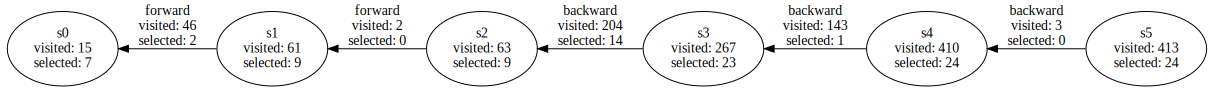

In [24]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.ffbb()
FinalSelection(state)

In [25]:
name = "E7"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

6,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.467,0.137,0.212,0.000,0.000,0.000,-,7,15,0,7,15,6,0.467,0.137,0.212,0.400,0.200,0.267
1,s1,0.043,0.039,0.041,0.000,0.000,0.000,forward,2,46,0,9,61,6,0.148,0.176,0.161,0.098,0.200,0.132
2,s2,0.000,0.000,0.000,0.000,0.000,0.000,forward,0,2,0,9,63,6,0.143,0.176,0.158,0.095,0.200,0.129
3,s3,0.069,0.275,0.110,0.039,0.267,0.068,backward,14,204,8,23,267,14,0.086,0.451,0.145,0.052,0.467,0.094
4,s4,0.007,0.020,0.010,0.007,0.033,0.012,backward,1,143,1,24,410,15,0.059,0.471,0.104,0.037,0.500,0.068
5,s5,0.000,0.000,0.000,0.000,0.000,0.000,backward,0,3,0,24,413,15,0.058,0.471,0.103,0.036,0.500,0.068


# Analyses

In [26]:
%matplotlib inline
import pandas as pd

In [27]:
df = pd.DataFrame (array,columns = [
    'Estratégia', 'Related', 'Visited', 'Final Selected', 
    'Precision', 'Recall', 'F-Measure',
    'Final Precision', 'Final Recall', 'Final F-Measure'])
df.index = df['Estratégia']
df
print (array)

d_decimals = 2    
for coluna in ['Precision', 'Recall', 'F-Measure', 'Final Precision', 'Final Recall', 'Final F-Measure',]:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

[['E1', 22, 497, 15, 0.04426559356136821, 1.0, 0.08477842003853565, 0.030181086519114688, 0.5, 0.05692599620493359], ['E2', 51, 1873, 30, 0.027229044313934865, 1.0, 0.05301455301455301, 0.01601708489054992, 1.0, 0.03152916447714135], ['E3', 36, 1059, 22, 0.0339943342776204, 0.7058823529411765, 0.06486486486486487, 0.02077431539187913, 0.7333333333333333, 0.04040404040404041], ['E4', 44, 1174, 25, 0.03747870528109029, 0.8627450980392157, 0.07183673469387755, 0.02129471890971039, 0.8333333333333334, 0.04152823920265781], ['E5', 19, 292, 14, 0.06506849315068493, 0.37254901960784315, 0.1107871720116618, 0.04794520547945205, 0.4666666666666667, 0.08695652173913043], ['E6', 35, 565, 20, 0.061946902654867256, 0.6862745098039216, 0.11363636363636365, 0.035398230088495575, 0.6666666666666666, 0.06722689075630252], ['E7', 24, 413, 15, 0.05811138014527845, 0.47058823529411764, 0.10344827586206898, 0.03631961259079903, 0.5, 0.06772009029345372]]


,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,22,497,15,0.04,1.00,0.08,0.03,0.50,0.06
E2,E2,51,1873,30,0.03,1.00,0.05,0.02,1.00,0.03
E3,E3,36,1059,22,0.03,0.71,0.06,0.02,0.73,0.04
E4,E4,44,1174,25,0.04,0.86,0.07,0.02,0.83,0.04
E5,E5,19,292,14,0.07,0.37,0.11,0.05,0.47,0.09
E6,E6,35,565,20,0.06,0.69,0.11,0.04,0.67,0.07
E7,E7,24,413,15,0.06,0.47,0.10,0.04,0.50,0.07


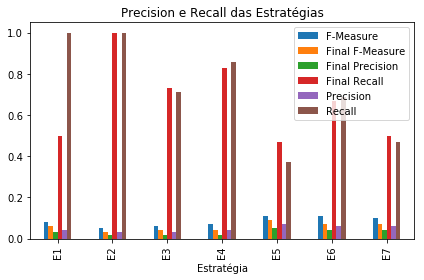

In [28]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df.loc[:, df.columns.difference(exclude)].plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [29]:
df

d_decimals = 2    
for coluna in ['Precision', 'Recall', 'F-Measure', 'Final Precision', 'Final Recall', 'Final F-Measure',]:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,22,497,15,0.04,1.00,0.08,0.03,0.50,0.06
E2,E2,51,1873,30,0.03,1.00,0.05,0.02,1.00,0.03
E3,E3,36,1059,22,0.03,0.71,0.06,0.02,0.73,0.04
E4,E4,44,1174,25,0.04,0.86,0.07,0.02,0.83,0.04
E5,E5,19,292,14,0.07,0.37,0.11,0.05,0.47,0.09
E6,E6,35,565,20,0.06,0.69,0.11,0.04,0.67,0.07
E7,E7,24,413,15,0.06,0.47,0.10,0.04,0.50,0.07


In [ ]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

In [ ]:
#len ({x for _, x in load_work_map_all_years() if x.category == "snowball"})

In [ ]:
#{x for _, x in load_work_map_all_years() if x.category == "snowball"} @ metakey_title